In [124]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import pyrosm
import matplotlib.pyplot as plt
import contextily as cx 
import pandana
import geocoder

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

'1.1.2'

In [49]:
# turn response caching off
ox.settings.use_cache=False  # If you are working on a project where you often re-download data, turning it off is recommended!

# turn it back on and turn on/off logging to your console
ox.settings.use_cache=True
ox.settings.log_console=False

### Localising potential pubcrawl locations with the tags 'pub' and 'bar'
- 603 bars/pubs

In [173]:
tags = {'amenity': ['pub', 'bar']}
pubs = ox.geometries_from_place(["Copenhagen Municipality", "Frederiksberg Municipality"], tags=tags)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


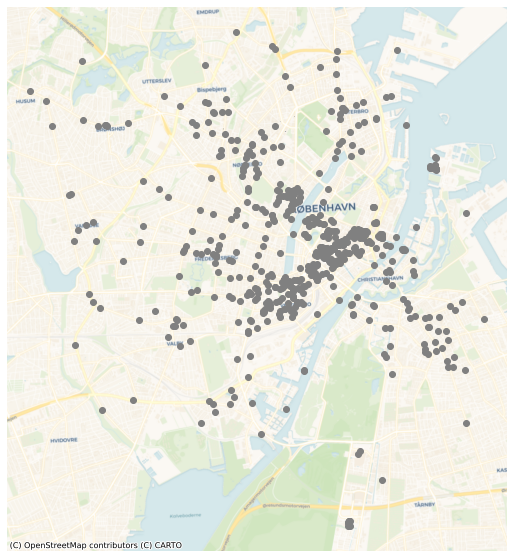

In [174]:
fig, ax = plt.subplots(figsize=(10,10))

pubs.to_crs("EPSG:25832").plot(ax=ax, color='grey')
ax.set_axis_off()
cx.add_basemap(
    ax=ax, 
    crs="EPSG:25832", 
    source=cx.providers.CartoDB.Voyager);

In [176]:
pubs.shape

(603, 108)

In [175]:
#only 215 pubsbars with available opening hours 
pubs[ pubs["opening_hours"].notna() ==True].shape

(215, 108)

In [223]:
pubs.geometry.y

name
Ølbaren                   6.177237e+06
Bankeråt                  6.176607e+06
Cafe Intime               6.175798e+06
Alléenberg                6.175597e+06
Cafe Svejk                6.175987e+06
                              ...     
Curfew                    6.175438e+06
Rascal                    6.176180e+06
Vespa Vinbar              6.175086e+06
Varmestuen PH Metropol    6.177321e+06
Lidkøb                    6.175437e+06
Length: 231, dtype: float64

# Network

In [235]:
#Finding the closest pubs near address
input_address = "2 Harsdorffsvej, Frederiksberg"
address_point =  ox.geocode("2 Harsdorffsvej, Frederiksberg")

tags = {'amenity': ['pub', 'bar']}


pubs = ox.geometries_from_point(
    address_point, tags=tags, dist=1000
)

In [236]:
#Some pubs might be polygons, but we need them as points, so extract the centroids from the geometries
pubs = pubs.to_crs('EPSG:25832')
pubs = pubs.set_index('name')[['geometry']]
pubs.geometry = pubs.centroid

In [237]:
pubs.shape

(95, 1)

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


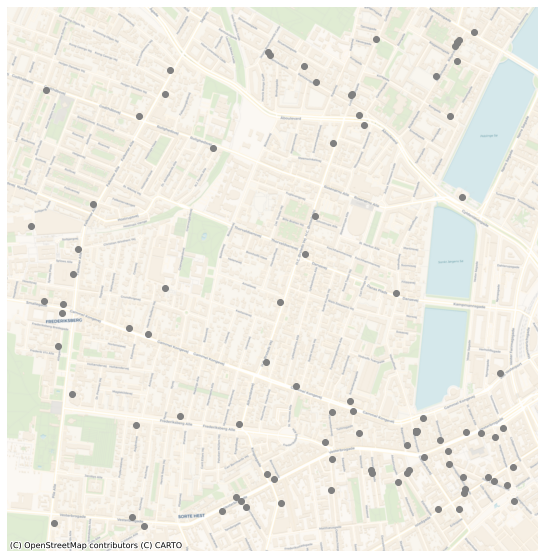

In [238]:
fig, ax = plt.subplots(figsize=(10,10))

pubs.to_crs("EPSG:25832").plot(ax=ax, color='grey')
ax.set_axis_off()
cx.add_basemap(
    ax=ax, 
    crs="EPSG:25832", 
    source=cx.providers.CartoDB.Voyager);

In [268]:
address_point

AttributeError: 'tuple' object has no attribute 'x'

In [212]:


G_walk = ox.graph_from_address(
    address=input_address,
    dist=1500,
    dist_type="network",
    network_type="walk",
)



In [213]:
# specify parameters for the analysis
walk_time = 30  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx


In [214]:
# set a uniform walking speed on every edge
for u, v, data in G_walk.edges(data=True):
    data['speed_kph'] = walk_speed
G_walk = ox.add_edge_travel_times(G_walk) # this computes the travel time in seconds based on the 'speed_kph' column

In [247]:
G_projected = ox.project_graph(G_walk, to_crs='EPSG:25832')
address_id = ox.nearest_nodes(G=G_walk, Y = address_point[0], X = address_point[1])
address_id

1635055395

In [266]:

c = ['r' if n == address_id or n == 1613469706 else 'w' for n in G_projected.nodes]

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


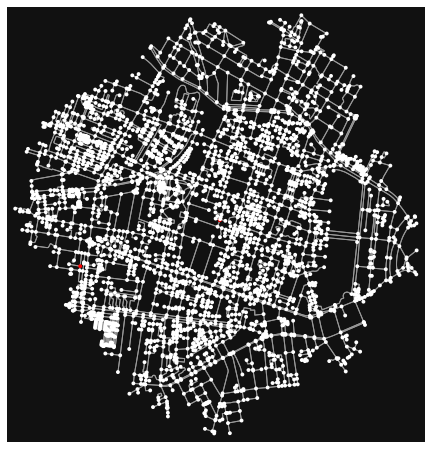

In [267]:


ox.plot_graph(G_projected, node_color=c);


In [250]:
pubs.geometry[0:5]

name
Cafe Intime          POINT (722072.533 6175797.797)
Alléenberg           POINT (722131.363 6175597.470)
Promenaden           POINT (722580.486 6175504.585)
London Pub           POINT (722408.561 6176754.842)
The Old Irish Pub    POINT (722092.169 6175973.469)
Name: geometry, dtype: geometry

In [265]:
routes = []
for idx, i in enumerate(pubs.geometry[0:5]): 
    print(idx, i)
    bar_id = ox.nearest_nodes(G=G_projected, Y = i.y, X = i.x)
    print("bar_id: ", bar_id)
    routes.append(ox.shortest_path(G_projected, address_id, bar_id, weight = "length"))

routes

0 POINT (722072.5327030021 6175797.797366798)
bar_id:  1613469706
1 POINT (722131.3629040745 6175597.470232088)
bar_id:  1626869403
2 POINT (722580.4862105066 6175504.584772891)
bar_id:  25256989
3 POINT (722408.5611573659 6176754.842000061)
bar_id:  726572
4 POINT (722092.1686110602 6175973.468515459)
bar_id:  7319413649


[[1635055395,
  781051,
  3468219209,
  781053,
  1635849659,
  1281445343,
  706670506,
  706670440,
  706687165,
  1624397514,
  1635849656,
  1331462683,
  1331462678,
  1624410019,
  1624364613,
  843607,
  7425141113,
  7425141114,
  7425141115,
  1624365778,
  1624365782,
  1624365786,
  4184934475,
  843584,
  1624998481,
  843586,
  1624969157,
  1624998482,
  1624963835,
  843587,
  4300898465,
  9969679348,
  9969679351,
  1624963037,
  843577,
  7489468384,
  1626917388,
  1626917375,
  833442021,
  3677269524,
  3250273561,
  3327855374,
  3567585928,
  257936276,
  1613469706],
 [1635055395,
  781051,
  3468219209,
  781053,
  1635849659,
  1281445343,
  706670506,
  706670440,
  706687165,
  1624397514,
  1635849656,
  1331462683,
  1331462678,
  1624410019,
  1624364613,
  843607,
  7425141113,
  7425141114,
  7425141115,
  1624365778,
  1624365782,
  1624365786,
  4184934475,
  1625123046,
  1624987832,
  843579,
  5257844077,
  5257844078,
  833442042,
  1626835582,
  

In [269]:
fig, ax = ox.plot_graph_routes(G_Projected, routes, route_colors = ["red", "blue", "yellow"])

NameError: name 'G_Projected' is not defined

## Trying Pandana .. no success

In [59]:
# Convert to pandana network. 
#"Pandana is a Python library for network analysis that uses contraction hierarchies to calculate super-fast travel accessibility metrics and shortest paths.
# For this we first need the nodes and edges as geodataframes

nodes = ox.graph_to_gdfs(G_projected, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(G_projected, nodes=False).reset_index()[['u', 'v', 'travel_time']]



network = pandana.Network(node_x=nodes['x'],
                          node_y=nodes['y'], 
                          edge_from=edges['u'],
                          edge_to=edges['v'],
                          edge_weights=edges[['travel_time']]) # we specify that we are interested in the length - but this could also be travel time, cost or something else

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 1746
Setting CH edge vector of size 4156
Range graph removed 4200 edges of 8312
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

In [155]:

network.set_pois(category='bar',
                 maxdist=walk_time_sec, 
                 maxitems=4, 
                 x_col=pubs.geometry.x, 
                 y_col=pubs.geometry.y)

Reading parameters from init_pois()


/opt/conda/lib/python3.9/site-packages/pandana/network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [150]:
network.pois()


AttributeError: 'Network' object has no attribute 'pois'

In [154]:
# calculate travel time to nearest 3 amenities from each node in network
distances = network.nearest_pois(distance=walk_time_sec,
                                 category='bar',
                                 num_pois=8
                                # ,include_poi_ids = True
                                )
distances


AssertionError: Asking for more pois than set in init_pois

In [ ]:
#convert it to minutes 
distances['travel_time'] = distances[1] / 60

In [ ]:
# Plot distance to nearest amenity from each node
fig, ax = ox.plot_graph(G_projected, node_size=0, edge_linewidth=0.1,
                        edge_color='gray', show=False, close=False)

sc = ax.scatter(x=nodes['x'],
                y=nodes['y'], 
                c=distances['travel_time'], # column to plot (distance to nearest store)
                s=1, # size
                cmap='inferno_r')

ax.set_title('Walking time to nearest bar')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')


In [ ]:
distances